In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt



                                                 r2       mae      rmse  \
V11L12_MOSCOT_selected_genes_full_msi     -0.025256  0.182345  0.232306   
V11L12_MOSCOT_selected_genes_selected_msi -0.049273  0.227927  0.296887   

                                            pearson  spearman  
V11L12_MOSCOT_selected_genes_full_msi      0.961866  0.893937  
V11L12_MOSCOT_selected_genes_selected_msi  0.970726  0.934880  


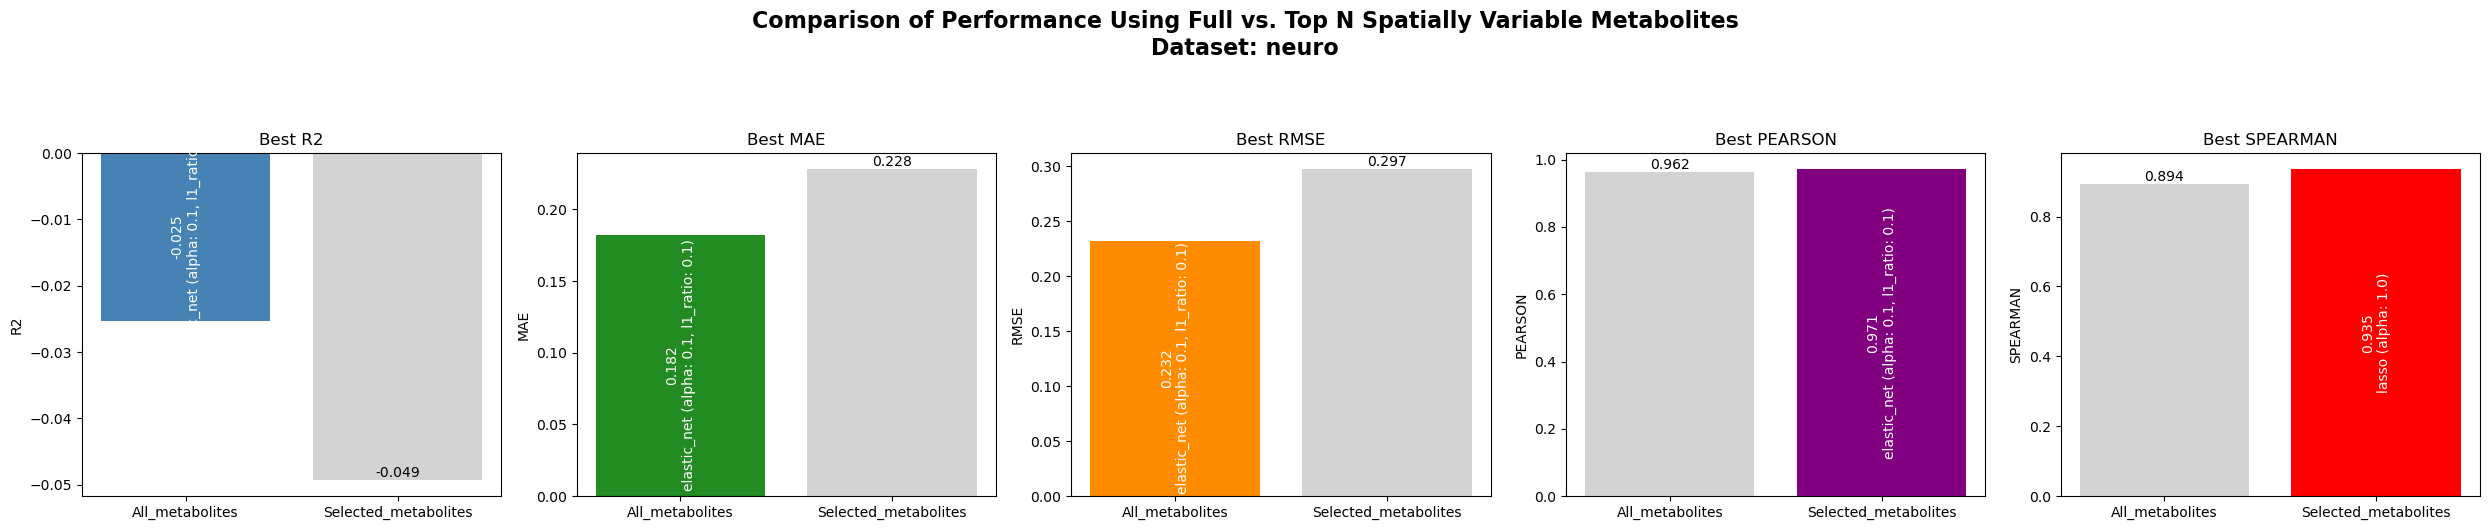

In [9]:
#List your tasks here
tasks = ['V11L12_MOSCOT_selected_genes_full_msi', 'V11L12_MOSCOT_selected_genes_selected_msi']

task_aliases = {
    'V11L12_MOSCOT_selected_genes_full_msi': 'All_metabolites',
    'V11L12_MOSCOT_selected_genes_selected_msi': 'Selected_metabolites'
}

base_dir = '/lustre/groups/ml01/workspace/eirini.giannakoulia/no_fs_pipeline/data/reports'
metrics = ['r2', 'mae', 'rmse', 'pearson', 'spearman']
best_direction = {
    'r2': 'max',
    'mae': 'min',
    'rmse': 'min',
    'pearson': 'max',
    'spearman': 'max'
}

# Define highlight colours for the best overall value of each metric.
highlight_colors = {
    'r2': 'steelblue',
    'mae': 'forestgreen',
    'rmse': 'darkorange',
    'pearson': 'purple',
    'spearman': 'red'
}
default_color = 'lightgray'

# Function to create a short summary of a method, based on its name and parameters.
def get_method_summary(method_name, method_params):
    try:
        # Convert to a dictionary if it's a string representation.
        if not isinstance(method_params, dict):
            params_dict = eval(method_params)
        else:
            params_dict = method_params
        # Get the first two key-value pairs.
        first_items = list(params_dict.items())[:2]
        params_info = ", ".join([f"{k}: {v}" for k, v in first_items])
        return f"{method_name} ({params_info})"
    except Exception:
        return f"{method_name}"

#Dictionaries to store the best metric values and the best method summaries for each task.
best_values = {}
best_methods = {}

for task in tasks:
    file_path = os.path.join(base_dir, task, 'merged_results.tsv')
    df = pd.read_csv(file_path, sep='\t')
    
    best_values[task] = {}
    best_methods[task] = {}
    
    for metric in metrics:
        if best_direction[metric] == 'max':
            idx = df[metric].idxmax()
        else:
            idx = df[metric].idxmin()
        best_val = df.loc[idx, metric]
        best_values[task][metric] = best_val
        
        # Get the method details and create a short summary.
        method_name = df.loc[idx, 'method_name']
        method_params = df.loc[idx, 'method_params']
        best_methods[task][metric] = get_method_summary(method_name, method_params)

# Convert the best values dictionary into a DataFrame (tasks as rows, metrics as columns).
best_df = pd.DataFrame.from_dict(best_values, orient='index')
print(best_df)

# Create a subplot for each metric.
num_metrics = len(metrics)
fig, axes = plt.subplots(1, num_metrics, figsize=(5 * num_metrics, 5), squeeze=False)

# Use task aliases (or fall back to original names) for the x-axis labels.
x_labels = [task_aliases.get(task, task) for task in best_df.index]

for i, metric in enumerate(metrics):
    ax = axes[0, i]
    # Determine the overall best value for the current metric.
    if best_direction[metric] == 'max':
        overall_best_value = best_df[metric].max()
    else:
        overall_best_value = best_df[metric].min()

    # Set colours: highlight the best bar.
    colors = [
        highlight_colors[metric] if best_df.loc[task, metric] == overall_best_value else default_color 
        for task in best_df.index
    ]
    
    bars = ax.bar(x_labels, best_df[metric], color=colors)
    
    # Annotate each bar.
    for bar, task in zip(bars, best_df.index):
        height = bar.get_height()
        if height == overall_best_value:
            # For the top model, include the value and method summary.
            label = f"{height:.3f}\n{best_methods[task][metric]}"
            # Place the label inside the bar with vertical text.
            ax.text(
                bar.get_x() + bar.get_width()/2, height/2, label,
                ha='center', va='center', fontsize=10, color='white', rotation=90
            )
        else:
            # For other bars, just display the numeric value above the bar.
            ax.text(
                bar.get_x() + bar.get_width()/2, height, f"{height:.3f}",
                ha='center', va='bottom', fontsize=10
            )
    
    ax.set_title(f"Best {metric.upper()}")
    ax.set_ylabel(metric.upper())
    # No need to rotate x-axis labels now that we use short alias names.
    ax.tick_params(axis='x', labelrotation=0)

ds_marker = 'neuro'

plt.suptitle(
    f"Comparison of Performance Using Full vs. Top N Spatially Variable Metabolites\nDataset: {ds_marker}",
    fontsize=16, fontweight='bold', y=1.05
)
# Reduce the gap between the title and the plots
plt.subplots_adjust(top=0.95)  # Moves plots up closer to the title

plt.tight_layout(rect=[0, 0, 1, 1])  # Further fine-tune layout

# plt.tight_layout(rect=[0, 0, 1, 0.55])  # Adjust layout to fit the titles


plt.tight_layout()

save_directory = '/lustre/groups/ml01/workspace/eirini.giannakoulia/no_fs_pipeline/visualizations'
filename = 'V11L12_MOSCOT_paired_selected_vs_full_msi(restricted_genes).png'
full_path = os.path.join(save_directory, filename)
os.makedirs(save_directory, exist_ok=True)
plt.savefig(full_path, dpi=300, bbox_inches='tight')

plt.show()
